In [1]:
import pandas as pd
import sklearn
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

%matplotlib inline

import statsmodels.api as sm
from statsmodels.api import OLS

import numpy as np

In [2]:
crime_property_light_population = pd.read_csv("./model_data/crime_light_density.csv")
crime_property_light_population.fillna(method='ffill', inplace=True)
# crime_property_light_population.dropna(inplace=True)
crime_property_light_population.head()

,Unnamed: 0,OFFENSE_CODE_GROUP,DISTRICT,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,STREET,Lat,Long,zipcode,Population density (per square mile of land area),BLDG_VAL,LAND_VAL,light_density
0,0,Auto Theft,E18,N,2019-10-13 09:28:24,2019,10,Sunday,9,LINCOLN ST,42.259518,-71.121563,2136,6206.9,455.644447,21.073507,0.437849
1,1,Auto Theft,E18,N,2019-10-12 20:11:26,2019,10,Saturday,20,METROPOLITAN AVE,42.262092,-71.116710,2136,6206.9,455.644447,21.073507,0.437849
2,2,Auto Theft,D14,N,2019-10-12 15:12:43,2019,10,Saturday,15,ALLSTON ST,42.352375,-71.135096,2134,16212.0,2250.588503,63.554783,0.582893
3,3,Auto Theft,D4,N,2019-10-12 04:41:52,2019,10,Saturday,4,SAINT JAMES AVE,42.349476,-71.076402,2116,32724.1,14799.401260,480.463801,0.656585
4,4,Auto Theft,A15,N,2019-10-02 08:08:49,2019,10,Wednesday,8,N MEAD ST,42.381846,-71.066551,2129,12192.0,278.377510,165.249738,0.678941


In [33]:
predictors = ['OFFENSE_CODE_GROUP','SHOOTING', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'Population density (per square mile of land area)', 'BLDG_VAL', 'LAND_VAL','light_density', 'Lat', 'Long']
# predictors = ['OFFENSE_CODE_GROUP','SHOOTING', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'Population density (per square mile of land area)', 'BLDG_VAL', 'LAND_VAL','light_density']

df = crime_property_light_population[predictors]


print(pd.DataFrame(df.OFFENSE_CODE_GROUP.value_counts()).head(15))

crime_type = ['Auto Theft', 'Motor Vehicle Accident Response', 'Larceny', 'Robbery', 'Residential Burglary']

df = df[df['OFFENSE_CODE_GROUP'].isin(crime_type)]

# count of each type before balancing
print(df.OFFENSE_CODE_GROUP.value_counts())



                                 OFFENSE_CODE_GROUP
Motor Vehicle Accident Response               40471
Larceny                                       33610
Medical Assistance                            31105
Investigate Person                            23700
Other                                         22575
Simple Assault                                20002
Vandalism                                     19376
Drug Violation                                19205
Verbal Disputes                               17538
Investigate Property                          14395
Towed                                         14179
Larceny From Motor Vehicle                    13133
Property Lost                                 12780
Warrant Arrests                                9913
Aggravated Assault                             9875
Motor Vehicle Accident Response    40471
Larceny                            33610
Residential Burglary                6857
Auto Theft                          5766
Robb

In [4]:
df.shape

(91968, 11)

In [5]:
# add light data's lat long
# add graffiti data's lat long
# analyze the max and min of the concatenated lat long respectively
# bin it
# merge with binning 
from sklearn.preprocessing import KBinsDiscretizer

grid_lat = np.linspace(42, 42.4, 192, endpoint='False')
grid_lat_pd = pd.DataFrame(grid_lat)
#Boston City
#21.96 km wide ==> 220 bins , 100m grid
#19.20 km long ==> 192 bins, 100m grid
#########################
lat_bin_count = 192
long_bin_count = 220
#########################

lat_enc = KBinsDiscretizer(n_bins=lat_bin_count, strategy='uniform', encode='ordinal')
long_enc = KBinsDiscretizer(n_bins=long_bin_count, strategy='uniform', encode='ordinal')




#left most: 42.281549, -71.191510
#right most: 42.325468, -70.922188

#southern most: 42.227155, -71.130342
#northern most: 42.397988, -71.000505
# Boston City's Rectangular boundary:

# lat : 42.227155 ~ 42.397988
# long : -71.191510 ~ -70.922188

boston_west = -71.191512
boston_east = -70.922185
boston_north = 42.397990
boston_south = 42.227150


df = df[df['Lat'] <= 42.397990]
df = df[df['Lat'] >= 42.227150]


df = df[df['Long'] <= -70.922185]
df = df[df['Long'] >= -71.191512]
print(len(df)) # result : 147858 ==> we don't lose any data (all rows are accurate)


df["latbin"] = lat_enc.fit_transform(pd.DataFrame(df.Lat))
df["longbin"] = long_enc.fit_transform(pd.DataFrame(df.Long))

# df["lonbin"] = df.Longitude.map(to_bin)
# groups = df.groupby(("latbin", "lonbin"))
# print((boston_north - boston_south) / 192.0  * 161 + boston_south)
df.head()

91968


,OFFENSE_CODE_GROUP,SHOOTING,MONTH,DAY_OF_WEEK,HOUR,Population density (per square mile of land area),BLDG_VAL,LAND_VAL,light_density,Lat,Long,latbin,longbin
0,Auto Theft,N,10,Sunday,9,6206.9,455.644447,21.073507,0.437849,42.259518,-71.121563,32.0,69.0
1,Auto Theft,N,10,Saturday,20,6206.9,455.644447,21.073507,0.437849,42.262092,-71.116710,35.0,75.0
2,Auto Theft,N,10,Saturday,15,16212.0,2250.588503,63.554783,0.582893,42.352375,-71.135096,142.0,53.0
3,Auto Theft,N,10,Saturday,4,32724.1,14799.401260,480.463801,0.656585,42.349476,-71.076402,138.0,123.0
4,Auto Theft,N,10,Wednesday,8,12192.0,278.377510,165.249738,0.678941,42.381846,-71.066551,176.0,135.0


In [6]:
light = pd.read_csv('./model_data/streetlight_locations.csv')
light = light[["Lat", "Long"]]

#########
lat_long_multiplier = 2

lat_bin_count3 = lat_bin_count * lat_long_multiplier
long_bin_count3 = long_bin_count * lat_long_multiplier
lat_enc3 = KBinsDiscretizer(n_bins=lat_bin_count3, strategy='uniform', encode='ordinal')
long_enc3 = KBinsDiscretizer(n_bins=long_bin_count3, strategy='uniform', encode='ordinal')
df["latbin3"] = lat_enc3.fit_transform(pd.DataFrame(df.Lat))
df["longbin3"] = long_enc3.fit_transform(pd.DataFrame(df.Long))
########

light["latbin3"] =  lat_enc3.fit_transform(pd.DataFrame(light.Lat))
light["longbin3"] =  long_enc3.fit_transform(pd.DataFrame(light.Long))
light.head()



light_count = pd.DataFrame(light.groupby(['latbin3', 'longbin3']).size())


light_count.columns = ['light_count']

light_count.to_csv("light_count.csv")
light2 = pd.read_csv('./light_count.csv')

print(light2["light_count"].max())

df = df.join(light2.set_index(['latbin3', 'longbin3']), on=['latbin3', 'longbin3'])

df["light_count"] = df["light_count"].fillna(0)
df.head()

24


,OFFENSE_CODE_GROUP,SHOOTING,MONTH,DAY_OF_WEEK,HOUR,Population density (per square mile of land area),BLDG_VAL,LAND_VAL,light_density,Lat,Long,latbin,longbin,latbin3,longbin3,light_count
0,Auto Theft,N,10,Sunday,9,6206.9,455.644447,21.073507,0.437849,42.259518,-71.121563,32.0,69.0,64.0,138.0,0.0
1,Auto Theft,N,10,Saturday,20,6206.9,455.644447,21.073507,0.437849,42.262092,-71.116710,35.0,75.0,71.0,150.0,0.0
2,Auto Theft,N,10,Saturday,15,16212.0,2250.588503,63.554783,0.582893,42.352375,-71.135096,142.0,53.0,284.0,106.0,2.0
3,Auto Theft,N,10,Saturday,4,32724.1,14799.401260,480.463801,0.656585,42.349476,-71.076402,138.0,123.0,277.0,247.0,0.0
4,Auto Theft,N,10,Wednesday,8,12192.0,278.377510,165.249738,0.678941,42.381846,-71.066551,176.0,135.0,353.0,270.0,0.0


# Below is grid scaling for bldg value ==> not so effective

In [7]:
# bldg = pd.read_csv('./model_data/union_2019_building_value.csv')
# bldg = bldg[["BLDG_VAL", "0", "1"]]
# bldg = bldg.dropna()
# bldg = bldg.rename(columns={"BLDG_VAL": "avg_BLDG_val", "0": "latitude", "1":"longitude"})
# print(len(bldg))
# bldg["latitude"] = bldg["latitude"].astype(float)
# # bldg["latitude"] = pd.to_numeric(df["latitude"],errors='coerce')
# bldg["longitude"] = bldg["longitude"].astype(float)


# bldg["latbin"] =  lat_enc.fit_transform(pd.DataFrame(bldg.latitude))
# bldg["longbin"] =  long_enc.fit_transform(pd.DataFrame(bldg.longitude))

# print(bldg['latbin'].unique())

# print(bldg[bldg['latbin']<42] .head())

# bldg_val_avg = pd.DataFrame(bldg.groupby(['latbin', 'longbin']).mean())
# bldg_val_avg.drop(['latitude', 'longitude' ], axis=1, inplace=True)
# print(bldg_val_avg.head())

# bldg_val_avg.to_csv("2019_avg_bldg_val.csv")

# bldg_val_avg2 = pd.read_csv('./2019_avg_bldg_val.csv')

# df = df.join(bldg_val_avg2.set_index(['latbin', 'longbin']), on=['latbin', 'longbin'])

# df["avg_BLDG_val"] = df["avg_BLDG_val"].fillna(0)
# df.head()

In [8]:
graffiti = pd.read_csv('./clean_data/boston_graffiti.csv')
graffiti = graffiti[graffiti["reason"] == 'Graffiti' ]
# graffiti.head()

#########
bin_multiplier = 3

lat_bin_count4 = lat_bin_count // bin_multiplier
long_bin_count4 = long_bin_count // bin_multiplier
lat_enc4 = KBinsDiscretizer(n_bins=lat_bin_count4, strategy='uniform', encode='ordinal')
long_enc4 = KBinsDiscretizer(n_bins=long_bin_count4, strategy='uniform', encode='ordinal')
df["latbin4"] = lat_enc4.fit_transform(pd.DataFrame(df.Lat))
df["longbin4"] = long_enc4.fit_transform(pd.DataFrame(df.Long))
########


graffiti["latbin4"] =  lat_enc4.fit_transform(pd.DataFrame(graffiti.latitude))
graffiti["longbin4"] =  long_enc4.fit_transform(pd.DataFrame(graffiti.longitude))
graffiti.head()

print(graffiti['latbin4'].unique())

graffiti_count = pd.DataFrame(graffiti.groupby(['latbin4', 'longbin4']).size())

graffiti_count.columns = ['graffiti_count']

print(graffiti_count.head())
graffiti_count.to_csv("graffiti_count.csv")

[30. 27. 44. 29. 50. 46. 28. 56. 25. 24. 35. 47. 45. 26. 52. 53. 43. 59.
 37. 48. 49. 36. 31. 34. 57. 33. 51. 41. 42. 62. 32. 21. 22. 20. 61. 39.
 15. 40. 38.  6. 18.  9. 14. 16. 23. 19. 12. 60. 13.  4.  2. 58. 17.  3.
 54. 10. 55.  7. 63.  8.  5. 11.  1.  0.]
                  graffiti_count
latbin4 longbin4                
0.0     18.0                   1
1.0     19.0                   2
2.0     18.0                   3
        19.0                   7
        20.0                   1


In [9]:
graffiti2 = pd.read_csv('./graffiti_count.csv')

print(graffiti2["graffiti_count"].max())

df = df.join(graffiti2.set_index(['latbin4', 'longbin4']), on=['latbin4', 'longbin4'])

df["graffiti_count"] = df["graffiti_count"].fillna(0)
df.head()

4413


,OFFENSE_CODE_GROUP,SHOOTING,MONTH,DAY_OF_WEEK,HOUR,Population density (per square mile of land area),BLDG_VAL,LAND_VAL,light_density,Lat,Long,latbin,longbin,latbin3,longbin3,light_count,latbin4,longbin4,graffiti_count
0,Auto Theft,N,10,Sunday,9,6206.9,455.644447,21.073507,0.437849,42.259518,-71.121563,32.0,69.0,64.0,138.0,0.0,10.0,23.0,8.0
1,Auto Theft,N,10,Saturday,20,6206.9,455.644447,21.073507,0.437849,42.262092,-71.116710,35.0,75.0,71.0,150.0,0.0,11.0,24.0,0.0
2,Auto Theft,N,10,Saturday,15,16212.0,2250.588503,63.554783,0.582893,42.352375,-71.135096,142.0,53.0,284.0,106.0,2.0,47.0,17.0,54.0
3,Auto Theft,N,10,Saturday,4,32724.1,14799.401260,480.463801,0.656585,42.349476,-71.076402,138.0,123.0,277.0,247.0,0.0,46.0,41.0,131.0
4,Auto Theft,N,10,Wednesday,8,12192.0,278.377510,165.249738,0.678941,42.381846,-71.066551,176.0,135.0,353.0,270.0,0.0,58.0,44.0,5.0


In [10]:
boston_shape = pd.read_csv("./clean_data/boston_shape_interpolation_data.csv")
boston_shape.head()
boston_geo_lat_long = boston_shape[["GEOID10","INTPTLAT10","INTPTLON10"]]

boston_geo_lat_long.head()

boston_social_vulnerability = pd.read_csv("./clean_data/Climate_Ready_Boston_Social_Vulnerability.csv")

boston_social_features =["GEOID10","Low_to_No"]
# boston_social_features =["GEOID10","HU100_RE"]

boston_low_income = boston_social_vulnerability[boston_social_features]

boston_low_income.head()

boston_low_income = boston_low_income.join(boston_geo_lat_long.set_index(['GEOID10']), on=['GEOID10'])
# boston_low_income.drop(['POP100_RE'], axis=1, inplace=True)

boston_low_income.rename(columns = {'INTPTLAT10':'lat', 'INTPTLON10':'long'}, inplace = True) 

boston_low_income.head()
########################
lat_long_divider = 10 # 20 3623

lat_bin_count2 = lat_bin_count // lat_long_divider
long_bin_count2 = long_bin_count // lat_long_divider

lat_enc2 = KBinsDiscretizer(n_bins=lat_bin_count2, strategy='uniform', encode='ordinal')
long_enc2 = KBinsDiscretizer(n_bins=long_bin_count2, strategy='uniform', encode='ordinal')
df["latbin2"] = lat_enc2.fit_transform(pd.DataFrame(df.Lat))
df["longbin2"] = long_enc2.fit_transform(pd.DataFrame(df.Long))
#########################



boston_low_income["latbin2"] =  lat_enc2.fit_transform(pd.DataFrame(boston_low_income.lat))
boston_low_income["longbin2"] =  long_enc2.fit_transform(pd.DataFrame(boston_low_income.long))

# print(boston_low_income['latbin2'].unique())
# print(boston_low_income['longbin2'].unique())




low_income_pop = pd.DataFrame(boston_low_income.groupby(['latbin2', 'longbin2']).mean())
low_income_pop.drop(['lat', 'long' ], axis=1, inplace=True)
low_income_pop.drop(['GEOID10'], axis=1, inplace=True)
print(low_income_pop)

low_income_pop.to_csv("low_income_pop_dist.csv")

low_income_pop2 = pd.read_csv('./low_income_pop_dist.csv')

# low_income_pop2.loc[low_income_pop2['latbin'] == 8]

                  Low_to_No
latbin2 longbin2           
0.0     2.0           666.0
        3.0           160.0
1.0     5.0           840.0
2.0     1.0          1911.0
        4.0           322.0
...                     ...
17.0    13.0         1587.0
        14.0          939.0
        15.0         2013.0
18.0    15.0            0.0
        16.0            0.0

[115 rows x 1 columns]


In [11]:
df = df.join(low_income_pop2.set_index(['latbin2', 'longbin2']), on=['latbin2', 'longbin2'])
df.head()

# print(df.loc[df['Low_to_No'].isna() == False].shape)
# df = df.loc[df['Low_to_No'].isna() == False]

,OFFENSE_CODE_GROUP,SHOOTING,MONTH,DAY_OF_WEEK,HOUR,Population density (per square mile of land area),BLDG_VAL,LAND_VAL,light_density,Lat,...,longbin,latbin3,longbin3,light_count,latbin4,longbin4,graffiti_count,latbin2,longbin2,Low_to_No
0,Auto Theft,N,10,Sunday,9,6206.9,455.644447,21.073507,0.437849,42.259518,...,69.0,64.0,138.0,0.0,10.0,23.0,8.0,3.0,6.0,NaN
1,Auto Theft,N,10,Saturday,20,6206.9,455.644447,21.073507,0.437849,42.262092,...,75.0,71.0,150.0,0.0,11.0,24.0,0.0,3.0,7.0,NaN
2,Auto Theft,N,10,Saturday,15,16212.0,2250.588503,63.554783,0.582893,42.352375,...,53.0,284.0,106.0,2.0,47.0,17.0,54.0,14.0,5.0,NaN
3,Auto Theft,N,10,Saturday,4,32724.1,14799.401260,480.463801,0.656585,42.349476,...,123.0,277.0,247.0,0.0,46.0,41.0,131.0,13.0,12.0,164.0
4,Auto Theft,N,10,Wednesday,8,12192.0,278.377510,165.249738,0.678941,42.381846,...,135.0,353.0,270.0,0.0,58.0,44.0,5.0,17.0,13.0,1587.0


In [12]:
# df["POP100_RE"] = df["POP100_RE"].fillna(0)
# df["HU100_RE"] = df["HU100_RE"].fillna(0)
df["Low_to_No"] = df["Low_to_No"].fillna(0)
# df["LEP"] = df["LEP"].fillna(0)
# df["POC2"] = df["POC2"].fillna(0)


# display(df.head(10))

# df['Low_to_No'] = df.groupby(['latbin','longbin']).Low_to_No.transform(lambda x: x.interpolate())
# df["POP100_RE"] = df.groupby(['latbin','longbin']).Low_to_No.transform(lambda x: x.interpolate())
# df["HU100_RE"] = df.groupby(['latbin','longbin']).Low_to_No.transform(lambda x: x.interpolate())

# df["POP100_RE"] = df["POP100_RE"].fillna(0)
# df["HU100_RE"] = df["HU100_RE"].fillna(0)
# df["Low_to_No"] = df["Low_to_No"].fillna(0)


df.head(10)


#POP100_RE: Tract population count
#HU100_RE: Tract housing unit count
#Low_to_No: # of population that has low to no income

,OFFENSE_CODE_GROUP,SHOOTING,MONTH,DAY_OF_WEEK,HOUR,Population density (per square mile of land area),BLDG_VAL,LAND_VAL,light_density,Lat,...,longbin,latbin3,longbin3,light_count,latbin4,longbin4,graffiti_count,latbin2,longbin2,Low_to_No
0,Auto Theft,N,10,Sunday,9,6206.9,455.644447,21.073507,0.437849,42.259518,...,69.0,64.0,138.0,0.0,10.0,23.0,8.0,3.0,6.0,0.0
1,Auto Theft,N,10,Saturday,20,6206.9,455.644447,21.073507,0.437849,42.262092,...,75.0,71.0,150.0,0.0,11.0,24.0,0.0,3.0,7.0,0.0
2,Auto Theft,N,10,Saturday,15,16212.0,2250.588503,63.554783,0.582893,42.352375,...,53.0,284.0,106.0,2.0,47.0,17.0,54.0,14.0,5.0,0.0
3,Auto Theft,N,10,Saturday,4,32724.1,14799.401260,480.463801,0.656585,42.349476,...,123.0,277.0,247.0,0.0,46.0,41.0,131.0,13.0,12.0,164.0
4,Auto Theft,N,10,Wednesday,8,12192.0,278.377510,165.249738,0.678941,42.381846,...,135.0,353.0,270.0,0.0,58.0,44.0,5.0,17.0,13.0,1587.0
9,Motor Vehicle Accident Response,N,9,Sunday,5,24074.6,5490.169358,260.905478,0.728900,42.332419,...,125.0,237.0,250.0,2.0,39.0,41.0,2.0,11.0,12.0,496.0
14,Residential Burglary,N,9,Sunday,4,14884.4,1040.984096,31.260815,0.640733,42.314630,...,104.0,195.0,208.0,0.0,32.0,34.0,4.0,9.0,10.0,784.0
16,Motor Vehicle Accident Response,N,9,Sunday,0,15913.2,1293.230035,31.015855,0.568578,42.287579,...,124.0,131.0,249.0,0.0,21.0,41.0,0.0,6.0,12.0,120.0
20,Motor Vehicle Accident Response,N,9,Saturday,22,15913.2,1293.230035,31.015855,0.568578,42.286065,...,131.0,127.0,262.0,0.0,21.0,43.0,8.0,6.0,13.0,0.0
21,Larceny,N,9,Sunday,3,28541.5,62047.075801,297.436153,0.816495,42.340070,...,151.0,255.0,303.0,0.0,42.0,50.0,7.0,12.0,15.0,0.0


In [13]:
# data balancing
crime_MVAR = df[df['OFFENSE_CODE_GROUP']=="Motor Vehicle Accident Response"]
crime_Larceny  = df[df['OFFENSE_CODE_GROUP']=="Larceny"]
crime_other_crime = df[(df['OFFENSE_CODE_GROUP']!="Motor Vehicle Accident Response") & (df['OFFENSE_CODE_GROUP']!="Larceny")]

t_size= 6500
#  keep about 6000 row for each crime
drop_MVAR, keep_MVAR = train_test_split(crime_MVAR, test_size=t_size/len(crime_MVAR), random_state = 109, stratify = crime_MVAR[['MONTH', 'DAY_OF_WEEK']])
drop_Larceny, keep_Larceny = train_test_split(crime_Larceny, test_size=t_size/len(crime_Larceny), random_state = 109, stratify = crime_Larceny[['MONTH', 'DAY_OF_WEEK']])

# combine data
balanced_data = pd.concat([keep_MVAR, keep_Larceny, crime_other_crime])

# count of each type after balancing 
balanced_data.OFFENSE_CODE_GROUP.value_counts()

Residential Burglary               6857
Larceny                            6500
Motor Vehicle Accident Response    6500
Auto Theft                         5766
Robbery                            5264
Name: OFFENSE_CODE_GROUP, dtype: int64

In [14]:
# balanced_data

In [15]:
#Let's label encode & one-hot encode the Categoricals (SHOOTING, DAY_OF_WEEK)
df = balanced_data

In [16]:


enc = OneHotEncoder(handle_unknown='ignore')

le = LabelEncoder() 
  
df['SHOOTING']= le.fit_transform(df['SHOOTING'])
df['DAY_OF_WEEK']= le.fit_transform(df['DAY_OF_WEEK']) 
df['OFFENSE_CODE_GROUP'] = le.fit_transform(df['OFFENSE_CODE_GROUP'])
df.reset_index(drop=True, inplace=True)

df_cat = enc.fit_transform(df[["SHOOTING", "MONTH", "DAY_OF_WEEK", "HOUR"]]).toarray()
df_cat = pd.DataFrame(df_cat, columns=enc.get_feature_names(['SHOOTING', 'MONTH', 'DAY_OF_WEEK', 'HOUR']))
df_cat.reset_index(drop=True, inplace=True)

df = pd.concat([df, df_cat], axis=1)
# print(df_cat.head())
df.head()

,OFFENSE_CODE_GROUP,SHOOTING,MONTH,DAY_OF_WEEK,HOUR,Population density (per square mile of land area),BLDG_VAL,LAND_VAL,light_density,Lat,...,HOUR_14,HOUR_15,HOUR_16,HOUR_17,HOUR_18,HOUR_19,HOUR_20,HOUR_21,HOUR_22,HOUR_23
0,2,0,9,5,8,14884.4,1040.984096,31.260815,0.640733,42.314915,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0,7,5,11,10617.5,1409.245482,46.711201,0.529223,42.311186,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0,4,6,14,11504.8,271.853366,28.739445,0.529698,42.286271,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,0,7,1,23,6206.9,455.644447,21.073507,0.437849,42.251208,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2,0,9,0,12,11504.8,271.853366,28.739445,0.529698,42.290439,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Dropping duplicate features (due to grid scaling)

In [17]:
df.drop(['light_density'], axis=1, inplace=True)
df.drop(['latbin'], axis=1, inplace=True)
df.drop(['longbin'], axis=1, inplace=True)
df.drop(['latbin2'], axis=1, inplace=True)
df.drop(['longbin2'], axis=1, inplace=True)
df.drop(['latbin3'], axis=1, inplace=True)
df.drop(['longbin3'], axis=1, inplace=True)
df.drop(['latbin4'], axis=1, inplace=True)
df.drop(['longbin4'], axis=1, inplace=True)
df.drop(['BLDG_VAL'], axis=1, inplace=True)
df.drop(['SHOOTING'], axis=1, inplace=True)


# df.drop(['SHOOTING_1', 'HOUR_1','HOUR_3', 'HOUR_4', 'HOUR_5', 'HOUR_6'], axis=1, inplace=True)





In [18]:
df.head()

,OFFENSE_CODE_GROUP,MONTH,DAY_OF_WEEK,HOUR,Population density (per square mile of land area),LAND_VAL,Lat,Long,light_count,graffiti_count,...,HOUR_14,HOUR_15,HOUR_16,HOUR_17,HOUR_18,HOUR_19,HOUR_20,HOUR_21,HOUR_22,HOUR_23
0,2,9,5,8,14884.4,31.260815,42.314915,-71.095303,0.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,7,5,11,10617.5,46.711201,42.311186,-71.110104,1.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,4,6,14,11504.8,28.739445,42.286271,-71.136442,1.0,29.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,7,1,23,6206.9,21.073507,42.251208,-71.130954,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2,9,0,12,11504.8,28.739445,42.290439,-71.132774,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'OFFENSE_CODE_GROUP'], 
                                                         df.OFFENSE_CODE_GROUP, test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = df.OFFENSE_CODE_GROUP)

In [20]:
#Let's scale the variables
min_max_scaler = MinMaxScaler()

# standard_scaler = StandardScaler()

# numerical = ["Population density (per square mile of land area)", "BLDG_VAL", "LAND_VAL", "light_density"]
to_standardize = ['Population density (per square mile of land area)','BLDG_VAL', 'LAND_VAL', 'Lat', 'Long', 'latbin', 'longbin', 'light_count',
       'avg_BLDG_val', 'graffiti_count']
not_standardize = list(df_cat.columns)
not_standardize.append('SHOOTING')
not_standardize.append('MONTH')
not_standardize.append('DAY_OF_WEEK')
not_standardize.append('HOUR')

min_max_scaler.fit(X_train)

# standard_scaler.fit(X_train[to_standardize])

X_normalized = pd.DataFrame(min_max_scaler.transform(X_train))
# X_normalized = pd.concat([pd.DataFrame(standard_scaler.transform(X_train[to_standardize])),
#                          pd.DataFrame(X_train[not_standardize])]
#                          , axis=1 )

X_normalized.columns = X_train.columns
X_normalized_tst = pd.DataFrame(min_max_scaler.transform(X_test))
# X_normalized_tst = pd.concat([pd.DataFrame(standard_scaler.transform(X_test[to_standardize])),
#                          pd.DataFrame(X_test[not_standardize])]
#                          , axis=1 )

X_normalized_tst.columns = X_test.columns


# X_normalized.drop(['SHOOTING'], axis=1, inplace=True)
# X_normalized_tst.drop(['SHOOTING'], axis=1, inplace=True)
X_normalized.drop(['MONTH'], axis=1, inplace=True)
X_normalized_tst.drop(['MONTH'], axis=1, inplace=True)
X_normalized.drop(['DAY_OF_WEEK'], axis=1, inplace=True)
X_normalized_tst.drop(['DAY_OF_WEEK'], axis=1, inplace=True)
X_normalized.drop(['HOUR'], axis=1, inplace=True)
X_normalized_tst.drop(['HOUR'], axis=1, inplace=True)
X_normalized.head()

,Population density (per square mile of land area),LAND_VAL,Lat,Long,light_count,graffiti_count,Low_to_No,SHOOTING_0,MONTH_1,MONTH_2,...,HOUR_14,HOUR_15,HOUR_16,HOUR_17,HOUR_18,HOUR_19,HOUR_20,HOUR_21,HOUR_22,HOUR_23
0,0.177558,0.190190,0.870602,0.658606,0.000000,0.009517,0.000000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.167550,0.010112,0.262990,0.251981,0.230769,0.000000,0.135678,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.350611,0.316373,0.637782,0.560290,0.153846,0.019941,0.000000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.177558,0.190190,0.903671,0.661141,0.000000,0.000680,0.337042,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.229294,0.116790,0.543412,0.664173,0.000000,0.000680,0.000000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
X_normalized.drop(['SHOOTING_0', 'MONTH_1', 'DAY_OF_WEEK_0', 'HOUR_0'], axis=1, inplace=True)
X_normalized_tst.drop(['SHOOTING_0', 'MONTH_1', 'DAY_OF_WEEK_0', 'HOUR_0'], axis=1, inplace=True)
X_normalized

,Population density (per square mile of land area),LAND_VAL,Lat,Long,light_count,graffiti_count,Low_to_No,MONTH_2,MONTH_3,MONTH_4,...,HOUR_14,HOUR_15,HOUR_16,HOUR_17,HOUR_18,HOUR_19,HOUR_20,HOUR_21,HOUR_22,HOUR_23
0,0.177558,0.190190,0.870602,0.658606,0.000000,0.009517,0.000000,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.167550,0.010112,0.262990,0.251981,0.230769,0.000000,0.135678,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.350611,0.316373,0.637782,0.560290,0.153846,0.019941,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.177558,0.190190,0.903671,0.661141,0.000000,0.000680,0.337042,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.229294,0.116790,0.543412,0.664173,0.000000,0.000680,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24704,0.406600,1.000000,0.760544,0.597765,0.000000,0.007931,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
24705,0.231752,0.013115,0.403832,0.635204,0.000000,0.003626,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
24706,0.231142,0.020764,0.518708,0.553307,0.000000,0.001360,0.836324,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
24707,0.231752,0.013115,0.354039,0.631496,0.000000,0.003399,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Best so far Log : 32.33 ( bin factor :4)

In [22]:
# balanced data
# Let's first start with Logistic Model

logreg = LogisticRegression(random_state = 0, solver='lbfgs', multi_class='multinomial', max_iter = 1000)
logreg.fit(X_normalized, y_train)
y_pred = logreg.predict(X_normalized_tst)


mcm = multilabel_confusion_matrix(y_test, y_pred, sample_weight=None, labels=None, samplewise=False)
logreg.score(X_normalized_tst , y_test)

0.3196827452249919

In [23]:
logreg.score(X_normalized, y_train)

0.3168885831073698

In [24]:
# knn = KNeighborsClassifier(n_neighbors = 7).fit(X_normalized, y_train) 
  
# # accuracy on X_test 
# accuracy = knn.score(X_normalized_tst, y_test) 
# print(accuracy)

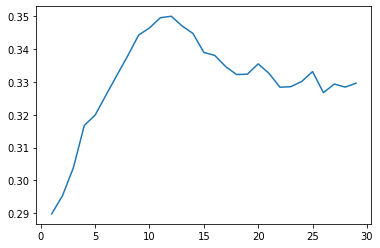

In [25]:
# decision tree with best depth by cv
depth_list = range(1,30)
score_list = []

for depth in depth_list:
#     print(depth)
    clf = DecisionTreeClassifier(random_state=0, criterion='gini', max_depth=depth)
    score = np.mean(cross_val_score(clf, X_normalized, y_train, cv=5))
    score_list.append(score)
plt.plot(depth_list, score_list)
plt.show()

In [26]:
best_depth = depth_list[np.argmax(score_list)]
best_depth

12

In [27]:
clf = DecisionTreeClassifier(random_state=0, max_depth=best_depth)
clf.fit(X_normalized, y_train)
clf.score(X_normalized_tst, y_test)

0.3471997410165102

[33 25 28 31 34 27 29 26 23 37 16  7 17 35  8 36 32 30 18 39 12 38 24  0
 15 11 14  9 40 13 41 10 22 19 20 21  6  4  5  1  2  3]


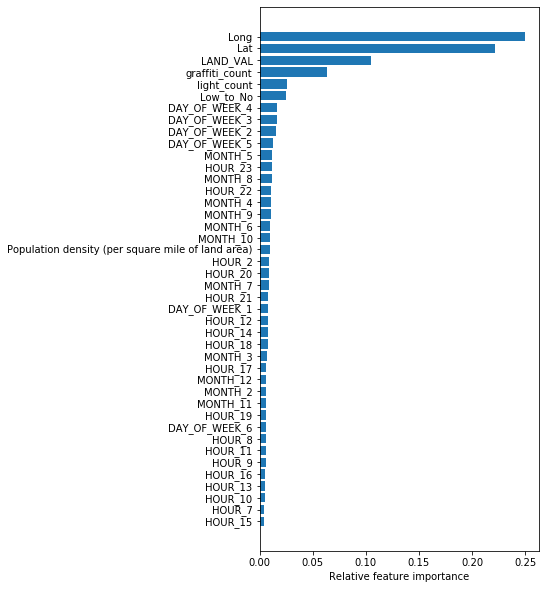

In [28]:
# plot feature importances
plt.figure(figsize=(5,10))
features = X_normalized.columns
feature_importances = clf.feature_importances_
idx = np.argsort(feature_importances)
print(idx)
plt.barh(y=features[idx], width=feature_importances[idx])
plt.xlabel("Relative feature importance")
plt.show()